In [ ]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tqdm import tqdm

IMG_SIZE = 28
CHANNELS = 1
NUM_CLASSES = 10
NULL_CLASS = NUM_CLASSES

BATCH_SIZE = 64
TIMESTEPS = 300
MAX_EPOCHS = 40
VAL_SPLIT = 0.1
PATIENCE = 12
MIN_DELTA = 1e-4

INITIAL_LR = 2e-4
CLIP_NORM = 1.0
EMA_DECAY = 0.999
COND_DROPOUT_PROB = 0.05

WEIGHTS_PATH = "ddpm.weights.h5"


def load_data():
    pct = int((1 - VAL_SPLIT) * 100)
    tr_raw, va_raw = tfds.load(
        "mnist",
        split=[f"train[:{pct}%]", f"train[{pct}%:]"],
        as_supervised=True,
    )

    def prep(img, lbl):
        img = tf.cast(img, tf.float32) / 255.0
        img = img * 2.0 - 1.0
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
        if img.shape.rank == 2:
            img = tf.expand_dims(img, -1)
        return img, tf.cast(lbl, tf.int32)

    tr = tr_raw.map(prep).shuffle(10000).batch(BATCH_SIZE).prefetch(2)
    va = va_raw.map(prep).batch(BATCH_SIZE).prefetch(2)
    return tr, va


def cosine_beta_schedule(t, s=0.008):
    x = tf.cast(tf.range(t + 1), tf.float32)
    ac = tf.cos(((x / (t + 1)) + s) / (1 + s) * (math.pi / 2)) ** 2
    ac = ac / ac[0]
    betas = 1.0 - (ac[1:] / ac[:-1])
    return tf.clip_by_value(betas, 1e-8, 0.999)


betas = cosine_beta_schedule(TIMESTEPS).numpy()
alphas = 1.0 - betas
alpha_hats = np.cumprod(alphas)
sqrt_alpha_hats = np.sqrt(alpha_hats)
sqrt_one_minus_alpha_hats = np.sqrt(1 - alpha_hats)


def gather_1d(arr, t, r=3):
    v = tf.gather(arr, t)
    for _ in range(r):
        v = tf.expand_dims(v, -1)
    return v


def timestep_embedding(t, d=128):
    h = d // 2
    freqs = tf.exp(-tf.math.log(10000.) * tf.cast(tf.range(h), tf.float32) / tf.cast(h, tf.float32))
    t = tf.cast(tf.reshape(t, (-1, 1)), tf.float32)
    a = t * tf.reshape(freqs, (1, -1))
    e = tf.concat([tf.sin(a), tf.cos(a)], axis=-1)
    if d % 2 == 1:
        e = tf.pad(e, [[0, 0], [0, 1]])
    return e


def ResBlock(x, cemb):
    ch = x.shape[-1]
    h = layers.LayerNormalization(axis=-1)(x)
    h = layers.Activation("silu")(h)
    h = layers.Conv2D(ch, 3, padding="same")(h)
    tproj = layers.Dense(ch)(cemb)
    tproj = layers.Reshape((1, 1, ch))(tproj)
    h = layers.Add()([h, tproj])
    h = layers.LayerNormalization(axis=-1)(h)
    h = layers.Activation("silu")(h)
    h = layers.Conv2D(ch, 3, padding="same")(h)
    return layers.Add()([x, h])


def build_model(f=64, c=128):
    img = keras.Input((IMG_SIZE, IMG_SIZE, CHANNELS))
    t = keras.Input((), dtype=tf.int32)
    y = keras.Input((), dtype=tf.int32)

    t_emb = layers.Lambda(lambda tt: timestep_embedding(tt, c))(t)
    y_emb = layers.Embedding(NUM_CLASSES + 1, c)(y)
    cond = layers.Add()([t_emb, y_emb])
    cond = layers.Dense(c, activation="silu")(cond)
    cond = layers.Dense(c, activation="silu")(cond)

    ychan = layers.Dense(IMG_SIZE * IMG_SIZE)(y_emb)
    ychan = layers.Reshape((IMG_SIZE, IMG_SIZE, 1))(ychan)

    x = layers.Concatenate()([img, ychan])
    x = layers.Conv2D(f, 3, padding="same")(x)
    x = ResBlock(x, cond)
    s1 = ResBlock(x, cond)

    x = layers.Conv2D(f * 2, 3, strides=2, padding="same")(s1)
    x = ResBlock(x, cond)
    s2 = ResBlock(x, cond)

    x = layers.Conv2D(f * 4, 3, strides=2, padding="same")(s2)
    x = ResBlock(x, cond)
    x = ResBlock(x, cond)

    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, s2])
    x = ResBlock(x, cond)
    x = ResBlock(x, cond)

    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, s1])
    x = ResBlock(x, cond)
    x = ResBlock(x, cond)

    out = layers.Conv2D(CHANNELS, 3, padding="same")(x)
    return keras.Model([img, t, y], out)


model = build_model()
ema_vars = [tf.Variable(w, trainable=False) for w in model.weights]


@tf.function
def ema_update():
    for w, ew in zip(model.weights, ema_vars):
        ew.assign(EMA_DECAY * ew + (1 - EMA_DECAY) * w)


def store_w():
    return [tf.identity(w) for w in model.weights]


def restore_w(ws):
    for v, s in zip(model.weights, ws):
        v.assign(s)


def apply_ema():
    for v, ew in zip(model.weights, ema_vars):
        v.assign(ew)


train_ds, val_ds = load_data()
steps = int(tf.data.experimental.cardinality(train_ds).numpy())
total_steps = MAX_EPOCHS * steps

lr = keras.optimizers.schedules.CosineDecay(INITIAL_LR, total_steps, alpha=0.1)
opt = keras.optimizers.Adam(lr, clipnorm=CLIP_NORM)


@tf.function
def train_step(batch):
    x, y = batch
    mask = tf.less(tf.random.uniform(tf.shape(y)), COND_DROPOUT_PROB)
    ycf = tf.where(mask, tf.fill(tf.shape(y), NULL_CLASS), y)
    b = tf.shape(x)[0]
    t = tf.random.uniform((b,), 0, TIMESTEPS, dtype=tf.int32)
    n = tf.random.normal(tf.shape(x))
    xt = gather_1d(sqrt_alpha_hats, t) * x + gather_1d(sqrt_one_minus_alpha_hats, t) * n
    with tf.GradientTape() as tape:
        p = model([xt, t, ycf], training=True)
        loss = tf.reduce_mean(tf.square(p - n))
    g = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(g, model.trainable_variables))
    ema_update()
    return loss


@tf.function
def val_step(x, y):
    mask = tf.less(tf.random.uniform(tf.shape(y)), COND_DROPOUT_PROB)
    ycf = tf.where(mask, tf.fill(tf.shape(y), NULL_CLASS), y)
    b = tf.shape(x)[0]
    t = tf.random.uniform((b,), 0, TIMESTEPS, dtype=tf.int32)
    n = tf.random.normal(tf.shape(x))
    xt = gather_1d(sqrt_alpha_hats, t) * x + gather_1d(sqrt_one_minus_alpha_hats, t) * n
    p = model([xt, t, ycf], training=False)
    return tf.reduce_mean(tf.square(p - n))


best = np.inf
p = 0

for e in range(MAX_EPOCHS):
    losses = []
    bar = tqdm(train_ds, desc=f"Epoch {e+1}/{MAX_EPOCHS}")
    for batch in bar:
        l = float(train_step(batch))
        losses.append(l)
        bar.set_postfix(loss=np.mean(losses[-50:]))

    vloss = [float(val_step(x, y)) for x, y in val_ds]
    v = np.mean(vloss)

    print(f"\nEpoch {e+1}: best={best:.6f} | val={v:.6f}")

    if v < best - MIN_DELTA:
        best = v
        p = 0
        saved = store_w()
        apply_ema()
        model.save_weights(WEIGHTS_PATH)
        restore_w(saved)
    else:
        p += 1
        if p >= PATIENCE:
            print("Early stopping.")
            break

print("\nTraining finished. Saved:", WEIGHTS_PATH)


Loading checkpoint: ddpm_mnist_cond_best_noattn.weights.h5
✓ Loaded successfully.


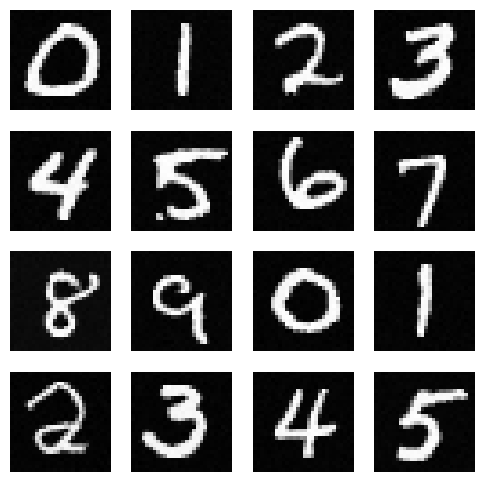

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import math
import os

IMG_SZ2 = 28
CH2 = 1
CLS = 10
NULL_CLS = CLS
TIMESTEPS2 = 300
G_SCALE = 2.0

CKPT2 = "ddpm_mnist_cond_best_noattn.weights.h5"

def cosine_beta_schedule2(timesteps, s=0.008):
    x = tf.cast(tf.range(timesteps + 1), tf.float32)
    ac = tf.cos(((x / (timesteps + 1)) + s) / (1 + s) * math.pi / 2) ** 2
    ac = ac / ac[0]
    betas = 1 - (ac[1:] / ac[:-1])
    return tf.clip_by_value(betas, 1e-8, 0.999)

betas2 = cosine_beta_schedule2(TIMESTEPS2).numpy()
alphas2 = 1.0 - betas2
alpha_hats2 = np.cumprod(alphas2)

def timestep_embedding2(t, dim=128):
    half = dim // 2
    freqs = tf.exp(-math.log(10000.0) * tf.range(half, dtype=tf.float32) / float(half))
    t = tf.cast(t, tf.float32)
    t = tf.reshape(t, (-1, 1))
    x = t * tf.reshape(freqs, (1, -1))
    return tf.concat([tf.sin(x), tf.cos(x)], axis=1)

def ResBlock2(x, cond_emb):
    c = x.shape[-1]
    h = layers.LayerNormalization(axis=-1)(x)
    h = layers.Activation("silu")(h)
    h = layers.Conv2D(c, 3, padding="same")(h)
    t_proj = layers.Reshape((1, 1, c))(layers.Dense(c)(cond_emb))
    h = layers.Add()([h, t_proj])
    h = layers.LayerNormalization(axis=-1)(h)
    h = layers.Activation("silu")(h)
    h = layers.Conv2D(c, 3, padding="same")(h)
    return layers.Add()([x, h])

def build_unet2(base_filters=64, cond_dim=128):
    img = keras.Input((IMG_SZ2, IMG_SZ2, CH2))
    t = keras.Input((), dtype=tf.int32)
    y = keras.Input((), dtype=tf.int32)

    t_emb = layers.Lambda(lambda tt: timestep_embedding2(tt, cond_dim), output_shape=(cond_dim,))(t)
    y_emb = layers.Embedding(CLS + 1, cond_dim)(y)
    cond_emb = layers.Add()([t_emb, y_emb])
    cond_emb = layers.Dense(cond_dim, activation="silu")(cond_emb)
    cond_emb = layers.Dense(cond_dim, activation="silu")(cond_emb)

    y_chan = layers.Dense(IMG_SZ2 * IMG_SZ2)(y_emb)
    y_chan = layers.Reshape((IMG_SZ2, IMG_SZ2, 1))(y_chan)
    x_in = layers.Concatenate()([img, y_chan])

    x = layers.Conv2D(base_filters, 3, padding="same")(x_in)
    x = ResBlock2(x, cond_emb)
    s1 = ResBlock2(x, cond_emb)

    x = layers.Conv2D(base_filters * 2, 3, strides=2, padding="same")(s1)
    x = ResBlock2(x, cond_emb)
    s2 = ResBlock2(x, cond_emb)

    x = layers.Conv2D(base_filters * 4, 3, strides=2, padding="same")(s2)
    x = ResBlock2(x, cond_emb)
    x = ResBlock2(x, cond_emb)

    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, s2])
    x = ResBlock2(x, cond_emb)
    x = ResBlock2(x, cond_emb)

    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, s1])
    x = ResBlock2(x, cond_emb)
    x = ResBlock2(x, cond_emb)

    out = layers.Conv2D(CH2, 3, padding="same")(x)
    return keras.Model([img, t, y], out)

print("Loading checkpoint:", CKPT2)
if not os.path.exists(CKPT2):
    raise FileNotFoundError("Checkpoint not found.")

gen_model = build_unet2()
gen_model.load_weights(CKPT2)
print("✓ Loaded successfully.")

def p_sample_step(x, t, eps, beta, alpha, alpha_cum):
    coef1 = 1.0 / tf.sqrt(alpha)
    coef2 = (1 - alpha) / tf.sqrt(1 - alpha_cum)
    mean = coef1 * (x - coef2 * eps)
    sigma = tf.sqrt(beta)
    return mean + sigma * tf.random.normal(tf.shape(x))

def gen_samples(n_samples, conditioning, guidance_scale):
    x = tf.random.normal((n_samples, IMG_SZ2, IMG_SZ2, CH2))
    cond = tf.convert_to_tensor(conditioning, dtype=tf.int32)
    for step in reversed(range(TIMESTEPS2)):
        t_batch = tf.fill((n_samples,), step)
        eps_u = gen_model([x, t_batch, tf.fill((n_samples,), NULL_CLS)], training=False)
        eps_c = gen_model([x, t_batch, cond], training=False)
        eps = eps_u + guidance_scale * (eps_c - eps_u)
        x = p_sample_step(x, t_batch, eps, betas2[step], alphas2[step], alpha_hats2[step])
    return (x + 1.0) * 0.5

n = 16
conds = np.arange(n) % CLS
imgs = gen_samples(n, conds, G_SCALE).numpy()

fig, ax = plt.subplots(4, 4, figsize=(6, 6))
for i, a in enumerate(ax.flatten()):
    a.imshow(imgs[i].squeeze(), cmap="gray")
    a.axis("off")
plt.show()


Conditioning: [1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 7 8 8 8 8 9 9 9 9]


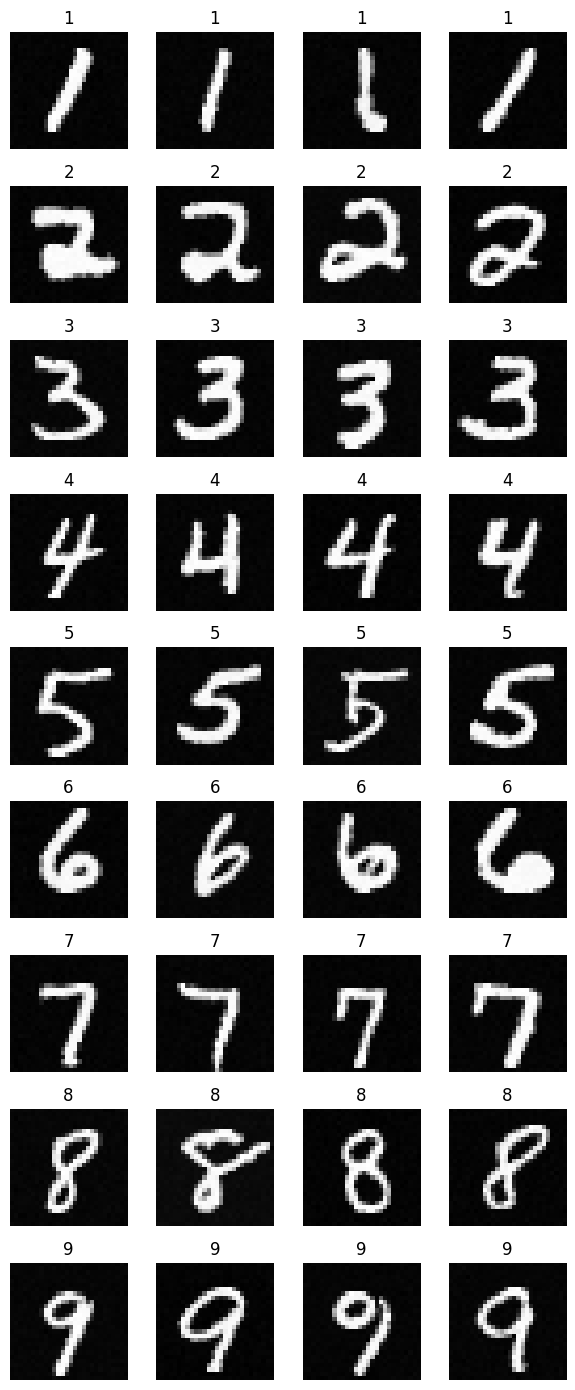

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


conds = np.concatenate([[d] * 4 for d in range(1, 10)])
n_samples = len(conds)

print("Conditioning:", conds)


imgs = sample_ddpm(
    n_samples=n_samples,
    conditioning=conds,
    guidance_scale=2.0
).numpy()


fig, ax = plt.subplots(9, 4, figsize=(6, 14))

idx = 0
for row in range(9):        # digits 1..9
    for col in range(4):    # 4 samples per digit
        ax[row, col].imshow(imgs[idx].squeeze(), cmap="gray")
        ax[row, col].set_title(str(conds[idx]))
        ax[row, col].axis("off")
        idx += 1

plt.tight_layout()
plt.show()
